# Intelligent Agents: Reflex Agents for the Vacuum-cleaner World


## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation (you can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or search algorithms),
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square is cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [3]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [4]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`. 

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned
        


Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: south
step 1 - action: east
step 2 - action: east
step 3 - action: south
step 4 - action: north
step 5 - action: suck
step 6 - action: east
step 7 - action: suck
step 8 - action: suck
step 9 - action: west
step 10 - action: south
step 11 - action: north
step 12 - action: suck
step 13 - action: north
step 14 - action: north
step 15 - action: east
step 16 - action: north
step 17 - action: east
step 18 - action: suck
step 19 - action: south


5

# Tasks

_Submission Instructions:_ Use this notebook to prepare your submission. Complete this section with your code and results. You can add additional Markdown blocks for your description, comments in the code and use mathplotlib to produce charts. 

_Note:_ Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design. 


## Task 1: Implement a simulation environment [2 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty.
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment needs to work with the simple randomized agent program from above and then it can be used for your agent implementation in the tasks below.

In [5]:
#PLOTTING CODE BORROWED FROM CLASS

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def show_room(room, pos, fontsize = 24):  
    """display room and robot
    
    Parameters
    ----------
    room : bool 2d array
        Dirt locations in the room.
    pos : list of 2 int values
        x and y location of the robot.
    fint_size : int
        size of the robot symbol.
    """
    
    cmap = colors.ListedColormap(['white', 'gray'])
    
    room = np.copy(room)    
    room = room.astype(np.int64)
    
    fig, ax = plt.subplots()
    ax.imshow(room, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N+1)), cmap.N))
    
    plt.text(pos[1], pos[0], u"\u2B24", fontsize = fontsize,
                 horizontalalignment = 'center', verticalalignment = 'center')
    
    plt.show()
    
#END BORROWED CODE

def environmentSimulation(agent, maxSteps, roomSize, verbose):
    
    #Initialize environment as empty 5x5 bool array, where dirty = True and clean = False
    enviro = np.empty((roomSize,roomSize), bool)
    numDirty = 0 #keeps track of number of dirty squares, used for telling if the program is finished

    #Iterate through and assign random values for clean and dirty
    for i in range(roomSize):
        for j in range(roomSize):
            #Assign squares as dirty or clean, 20% chance of being dirty (dirty = True)
            chance = np.random.randint(1, 100)

            if chance <= 20: #20/100 chance of being dirty
                enviro[i,j] = True
                numDirty += 1
            else:
                enviro[i,j] = False
    
    #Initialize agent information
    agentPos = [np.random.randint(0,roomSize - 1), np.random.randint(0,roomSize - 1)] #position is stored as a list [x,y] where x is the row number and y is the column number
    numActions = 0
    
    #Init bumpers
    bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}
    if agentPos[0] == 0:
        bumpers["north"] = True
    elif agentPos[0] == (roomSize - 1):
        bumpers["south"] = True
    else:
        bumpers["north"] = False
        bumpers["south"] = False

    if agentPos[1] == 0:
        bumpers["west"] = True
    elif agentPos[1] == (roomSize - 1):
        bumpers["east"] = True
    else:
        bumpers["west"] = False
        bumpers["east"] = False
        
    #Initial display
    #if verbose: show_room(enviro, agentPos)
    
    #Agent function loop
    while numDirty > 0 and numActions < maxSteps:
        dirty = enviro[agentPos[0], agentPos[1]]
        action = agent(bumpers, dirty) #Run agent function
        if action == "": break #None action means the agent has finished cleaning
        numActions += 1
        if action != "suck" and bumpers[action]: continue
        
        
        #Process result of agent function and update information
        if action == "north":
            agentPos[0] -= 1
        elif action == "south":
            agentPos[0] += 1
        elif action == "east":
            agentPos[1] += 1
        elif action == "west":
            agentPos[1] -= 1
        elif action == "suck" and enviro[agentPos[0], agentPos[1]]:
            enviro[agentPos[0], agentPos[1]] = False #square is now clean
            numDirty -= 1
        
        #Update bumpers
        if agentPos[0] == 0:
            bumpers["north"] = True
        elif agentPos[0] == (roomSize - 1):
            bumpers["south"] = True
        else:
            bumpers["north"] = False
            bumpers["south"] = False
            
        if agentPos[1] == 0:
            bumpers["west"] = True
        elif agentPos[1] == (roomSize - 1):
            bumpers["east"] = True
        else:
            bumpers["west"] = False
            bumpers["east"] = False
            
        if verbose:
            print("Step", numActions, ":", action)
            #show_room(enviro, agentPos)  #leaving out the graph for the report

    return numActions #return value is energy consumption

## Task 2:  Implement a simple reflex agent [1 Point] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [6]:
#Agent function
def simpleReflexAgent(bumpers, dirty):
    if dirty:
        return "suck"
    
    #Square is not dirty, choose a movement action randomly
    movementOptions = [] #options will be appended to this list if they are possible, based on the bumper status
    for direction in ["north", "south", "east", "west"]:
        if not bumpers[direction]:
            movementOptions.append(direction)
    
    #Choose a random movement from the possible list
    return np.random.choice(movementOptions)

environmentSimulation(simpleReflexAgent, 100, 5, True)

Step 1 : west
Step 2 : east
Step 3 : south
Step 4 : suck
Step 5 : south
Step 6 : suck
Step 7 : south
Step 8 : suck
Step 9 : south
Step 10 : suck
Step 11 : east
Step 12 : suck
Step 13 : west
Step 14 : north
Step 15 : south
Step 16 : east
Step 17 : west
Step 18 : east
Step 19 : north
Step 20 : suck
Step 21 : south
Step 22 : west
Step 23 : north
Step 24 : south
Step 25 : east
Step 26 : north
Step 27 : north
Step 28 : south
Step 29 : north
Step 30 : south
Step 31 : west
Step 32 : east
Step 33 : west
Step 34 : east
Step 35 : north
Step 36 : west
Step 37 : east
Step 38 : south
Step 39 : north
Step 40 : south
Step 41 : north
Step 42 : north
Step 43 : north
Step 44 : south
Step 45 : west
Step 46 : north
Step 47 : east
Step 48 : south
Step 49 : south
Step 50 : north
Step 51 : north
Step 52 : south
Step 53 : south
Step 54 : south
Step 55 : north
Step 56 : south
Step 57 : west
Step 58 : north
Step 59 : north
Step 60 : south
Step 61 : south
Step 62 : east
Step 63 : west
Step 64 : west
Step 65 : ea

100

## Task 3: Implement a model-based reflex agent [3 Point]

This agent keeps track of the location and remembers where it has cleaned. Assume the agent knows how many squares the room has. It can move to a corner to determine its location and then is able to use more advanced navigation.

Describe how you define the __agent state__ and how your agent works before implementing it. _Note on implementing the state in Python:_ [Examples](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)

#### Agent state

The agent is implemented with a class, and its state has 6 components:

* position (int, int): current (x, y) coordinates of robot, acquired after navigating to the corner
* navigation (string): atomic state variable with three possibilities describing current navigation function:
    * corner: position is unknown, navigating to corner to acquire position
    * size: roomSize is unknown, traveling east until hitting the wall to calculate room size
    * clean: position and roomSize are known, starting side-to-side cleaning sequence
* lastMove (string): stores the last movement action performed by the robot
* direction (string): current direction of travel in the cleaning sequence
* roomSize (int): size of the room
* cleaned (tuple array): list of all points where dirt was cleaned

The agent starts out with its position unknown (represented by (-1. -1) position), and its navigation state is "corner." In the corner state, the agent will travel north until hitting the wall, and west until hitting the wall. Now in position (0,0) the agent keeps track of its position. Once in (0,0), the navigation state transitions to "size." In this state, the agent travels east until the east bumper detects a wall. The agent then record the roomSize as current x position + 1, and transitions to "clean" state. In this state, the agent moves in straight horizontal lines to clean the entire room. It will travel straight in one direction until it has reached a position adjacent to the east or west wall. Then it will move south one square, and go back in the opposite direction. The agent stops when the position (roomSize - 1, roomSize - 1) has been reached.


In [50]:
class ModelReflexAgent:
    def __init__(self, posX = -1, posY = -1):
        self.x = posX
        self.y = posY
        self.lastMove = "" #keep track of the agent's last movement action, used for turning
        self.navigation = "corner"
        self.direction = "" #state of agent's orientation - which direction it is traveling
        self.roomSize = 0 #0 means agent does not know room size yet
        self.cleaned = [] #stores cleaned squares as (x,y) tuples
    
    #Main agent function
    def act(self, bumpers, dirty):
        if dirty:
            self.clean()
            return "suck"
        
        #Agent is in non cleaning state -> navigate to the NW corner
        if self.navigation == "corner":
            if not bumpers["north"]: return "north"
            if not bumpers["west"]: return "west"
            
            #Now in NW corner, set position
            self.x = 0
            self.y = 0
            self.navigation = "size"
        
        #Navigation state - go east until hitting the wall, keeping track of roomSize along the way
        if self.navigation == "size":
            if bumpers["east"]:
                self.navigation = "clean"
                self.roomSize = self.x + 1
            else:
                self.move("east")
                return "east"
            
        #Cleaning state - goes back and forth between east and west walls until whole room is cleaned
        if self.navigation == "clean":
            if (self.x, self.y) == (self.roomSize - 1, self.roomSize - 1):
                return "" #cleaning complete
            
            if self.x == 0 and self.lastMove != "south":
                self.move("south")
                self.direction = "east"
                return "south"
            elif self.x == (self.roomSize - 1) and self.lastMove != "south":
                self.move("south")
                self.direction = "west"
                return "south"
            else:
                self.move(self.direction)
                return self.direction
            
        
    #Cleaning function - called when the agent chooses "suck" action
    #Marks the current position as cleaned
    def clean(self):
        self.cleaned.append((self.x, self.y))
    
    #Adjusts position state
    def move(self, direction):
        if direction == "north": self.y -= 1
        elif direction == "south": self.y += 1
        elif direction == "east": self.x += 1
        else: self.x -= 1 #direction == "west"
        self.lastMove = direction
        
environmentSimulation(ModelReflexAgent().act, 50, 5, True)

Step 1 : west
Step 2 : suck
Step 3 : west
Step 4 : west
Step 5 : east
Step 6 : east
Step 7 : east
Step 8 : east
Step 9 : south
Step 10 : west
Step 11 : west
Step 12 : west
Step 13 : west
Step 14 : suck
Step 15 : south
Step 16 : east
Step 17 : east
Step 18 : east
Step 19 : east
Step 20 : suck
Step 21 : south
Step 22 : west
Step 23 : west
Step 24 : west
Step 25 : west
Step 26 : suck
Step 27 : south
Step 28 : east
Step 29 : suck


29

## Task 4: Simulation study [3 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results in a suitable format (tables, graphs) and discuss the differences. 

Here is some help with [charts and tables.](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/charts_and_tables.ipynb)

In [8]:
import matplotlib.pyplot as plt

#Simulation function: runs simulations for each agent
def simulate(avgList, scores, agentFunc, model = False):
    index = 0
    for i in [5, 10, 50, 100]: #Repeat trials for 4 different room sizes
        for j in range(100):
            if model:
                agentFunc = ModelReflexAgent().act #model agent needs a fresh object for each run
            data = environmentSimulation(agentFunc, 1000000, i, verbose=False) #1 million energy units is usually enough for all agents to completely clean all rooms
            avgList[index] += data
            scores[index][j] = data
            
        avgList[index] /= 100
        index += 1

#Initialize data arrays
randScores = np.empty((100,100), int)
reflexScores = np.empty((100,100), int)
modelScores = np.empty((100,100), int)
randAverages = np.zeros(4, int)
reflexAverages = np.zeros(4, int)
modelAverages = np.zeros(4, int)

#Run simulations
simulate(randAverages, randScores, simple_randomized_agent)
simulate(reflexAverages, reflexScores, simpleReflexAgent)
simulate(modelAverages, modelScores, None, True)

### Performance bar plots

In [1]:
#Bar plot

table = {"Room size": [5, 10, 50, 100], "Randomized agent": randAverages, "Simple reflex agent": reflexAverages, "Model reflex agent": modelAverages}
x = ["Randomized agent","Simple reflex agent","Model reflex agent"]

index = 0
for i in [5, 10, 50, 100]:
    dataArray = [randAverages[index], reflexAverages[index], modelAverages[index]]
    plt.bar(x, dataArray)
    plt.title("{}x{} Average Energy".format(i, i))
    plt.ylabel("Energy consumption")
    plt.show()
    index += 1

NameError: name 'randAverages' is not defined

#### Averages in table form

In [2]:
import pandas as pd

df = pd.DataFrame(table) #table variable initialized above
df
print()

NameError: name 'table' is not defined

The rows in this table correspond to the room size for the sample runs (5x5, 10x10 ... 100x100)

### Performance histograms
These histograms display the results from all 100 runs for each agent for each room size

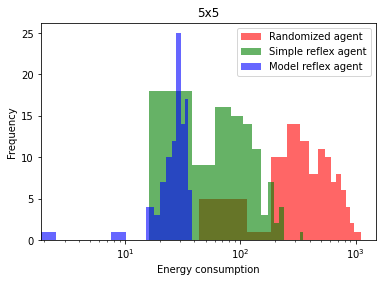

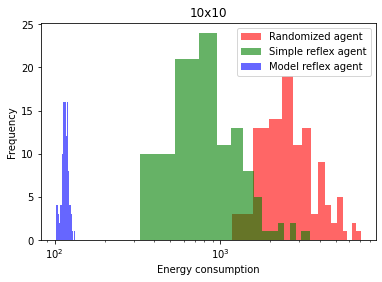

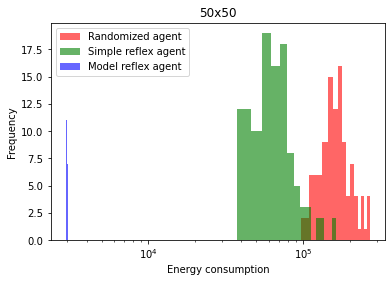

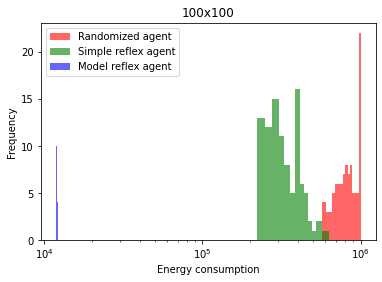

In [11]:
index = 0
for i in [5, 10, 50, 100]:
    plt.hist(randScores[index], bins = 15, alpha = .6, color='r', label="Randomized agent")
    plt.hist(reflexScores[index], bins = 15, alpha = .6, color='g', label="Simple reflex agent")
    plt.hist(modelScores[index], bins = 15, alpha = .6, color='b', label="Model reflex agent")
    plt.title("{}x{}".format(i, i))
    plt.legend()
    plt.xscale("log")
    plt.xlabel("Energy consumption")
    plt.ylabel("Frequency")
    plt.show()
    index += 1

### Analysis
For all room sizes, the model reflex agent is the most efficient, with the simple reflex agent coming in second, followed by the simple randomized agent in last. The difference in efficiency became more pronounced as the room size increased. The model agent's score was typically close to the total area of the room. This is expected, since the model agent's cleaning sequence takes exactly n^2 movement operations. The energy expenditure was increased by the random distance which the robot had to travel in order to reach the NW corner of the room. For the smaller rooms, this was negligible, but in the 100x100 room, this could take a maximum of 200 extra movements, depending on the randomly chosen position of the agent at start up.

The simple reflex agent, while not the most efficient, was a definite improvement from the randomized agent. Unlike the randomized agent, the simple reflex agent used its sensors and paid attention to its percepts, thus avoiding a lot of unnecessary "suck" actions, or choosing an invalid movement direction. However, the simple reflex agent was still limited by its lack of state memory. Without knowing its position or the layout of the room, the simple reflex agent often wandered around aimlessly.

## Task 5: Robustness of the agent implementations [1 Point] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

##### Simple Reflex Agent
* Unknown size: the agent should behave and perform similarly, since it does not take roomsize into account, and merely cleans randomly while paying attention to the bumpers
* Irregular shape: the agent would perform much worse, because it has no sense of how the room is shaped. If there is a narrow hallway leading to another room, it might get stuck in one room and never clean the other room
* Obstacles: the agent should perform well since the obstacles are functionally indistinguishable from a wall for this implementation. The agent will use its bumpers to avoid the obstacles, but it will not be able to perform any advanced navigation around them

##### Model Reflex Agent
* Unknown size: the rectangular shape of the room would throw off the agent's measurement of room size. It would be able to successfully measure one side length of the room, however I programmed it to assume that the room is a square, so it would only clean a square section of the rectangular room
* Irregular shape: the agent would perform poorly, since it is designed to clean a square shaped room. It would attempt to navigate to the NW corner of the room, and then clean out a square section of the room.
* Obstacles: the agent would think that the obstacles are a wall, and could cause an error in measuring the size of the room, or cause it to miss parts of the room during the cleaning phase, because it thinks that the obstacle it ran into was the wall


## Graduate student advanced task: Obstacles [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [12]:
# Your code and discussion goes here

## More advanced tasks to think about

You can think about these:

* __Unknown environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square.

* __Utility-based agent:__ Change the environment, so each square has a fixed probability of getting dirty again. We assume the agent has learned this information over time. For the implementation, we give this information to the agent as a 2-dimensional array of probabilities  Cleaning one dirty square produces a utility of 1. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 10000 time steps. This is very tricky!

In [13]:
# Your ideas/code